In [812]:
import csv
import patsy
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
with open('amazon_scrape_data.pkl', 'rb') as picklefile:
    df = pkl.load(picklefile)

with open('part_two_scrape.pkl', 'rb') as file:
    df1 = pkl.load(file)

In [4]:
# Data Cleaning Part 1
df = df[df['price'].str.contains('na') == False]
df = df[df['screensize'].str.contains('na') == False]
df = df[df['screensize'].str.contains('—') == False]
df = df[df['weight'].str.contains('—') == False]
df = df[df['rating'].str.contains('na') == False]
df = df[df['weight'].str.contains('a') == False]

df['rating'] = df['rating'].apply(lambda r: float(r[0:3]))
df['price'] = df['price'].apply(lambda p: p.strip('$'))
df['price'] = df['price'].apply(lambda p: p.replace(',','')).apply(lambda p: float(p))

In [5]:
df.head(3)

,product_name,rating,price,screensize,weight
0,BlackBerry Leap 16GB Factory Unlocked GSM 4G L...,3.2,79.72,5 in,6 ounces
2,Kyocera DuraForce E6560 16GB Unlocked GSM 4G L...,3.4,79.95,4.5 in,7.05 ounces
3,LG G2 D800 GSM 4G LTE Unlocked Smartphone with...,3.7,199.99,5.2 in,5.04 ounces


In [6]:
# Data Cleaning Part 2
screensize_replace = []
for size in df['screensize']:
    if 'in' in size:
        screensize_replace.append(float(size.strip(' in')))
    else:
        screensize_replace.append(float(size))
df['screensize'] = screensize_replace

In [7]:
df.weight.value_counts()

5.04 ounces    27
5.64 ounces    24
4.8 ounces     23
5.47 ounces    22
4.59 ounces    20
6 ounces       20
4.73 ounces    14
4.66 ounces    13
5.11 ounces    12
6.53 ounces    12
7.13 ounces    11
1.6 ounces     11
5.92 ounces    11
4.64 ounces    11
7.05 ounces    10
1.54 lbs       10
1.5 lbs        10
4.58 ounces    10
5.93 ounces     9
4.69 ounces     9
5.26 ounces     8
6.21 ounces     8
3.92 ounces     7
7.37 ounces     7
0.85 ounces     7
1 lb            7
0.66 lb         7
5.15 ounces     7
5.33 ounces     7
6.24 ounces     7
               ..
4.44 ounces     1
5.71 ounces     1
6.35 ounces     1
5.54 ounces     1
0.48 ounces     1
1.25 lbs        1
3.04 ounces     1
4.7 ounces      1
6.84 ounces     1
5.28 ounces     1
6.17 ounces     1
0.7 lb          1
4.55 ounces     1
6.5 ounces      1
3.3 ounces      1
0.82 lb         1
3.74 ounces     1
0.99 lb         1
0.64 lb         1
0.6 lb          1
6.42 ounces     1
4.6 ounces      1
1.44 ounces     1
5.96 ounces     1
7.02 ounce

In [8]:
df.reset_index(inplace=True)
df = df.drop(columns = ['index'])

In [232]:
# standardize all weights to 'ounces'
for w in range(0, len(df)):
    if 'ounces' in df.weight[w]:
        df.weight[w] = float(df.weight[w].strip(' ounces'))
    elif 'lbs' in df.weight[w]:
        df.weight[w] = float(df.weight[w].strip(' lbs'))*16
    else:
        df.weight[w] = float(df.weight[w].strip(' lb'))*16

TypeError: argument of type 'float' is not iterable

In [10]:
final_df = pd.concat([df, df1], axis = 1, join = 'inner')
final_df.head(5)

,product_name,rating,price,screensize,weight,memory,ram,battery,camera
0,BlackBerry Leap 16GB Factory Unlocked GSM 4G L...,3.2,79.72,5.0,6,16 GBMemory card,"2 GB, 533 MHz",2800 mAh,30
1,Kyocera DuraForce E6560 16GB Unlocked GSM 4G L...,3.4,79.95,4.5,7.05,16 GBMemory card,2 GB,3100 mAh,30
2,LG G2 D800 GSM 4G LTE Unlocked Smartphone with...,3.7,199.99,5.2,5.04,16 GBMemory card,"2 GB, 667 MHz",4500 mAh,30
3,HUAWEI Ascend Mate 2 16GB Unlocked GSM 6.1” Di...,4.1,199.99,6.1,7.13,16 GBMemory card,2 GB,4050 mAh,30
4,Samsung Galaxy S5 Active G870a 16GB Unlocked G...,3.3,189.99,5.1,6,16 GBMemory card,2 GB,4050 mAh,30


In [11]:
final_df = final_df[final_df['memory'].str.contains('ions') == False]
final_df = final_df[final_df['camera'].str.contains('\n') == False]
final_df = final_df[final_df['camera'] != '']
final_df['memory'] = final_df['memory'].apply(lambda m: m.strip(' ')).apply(lambda m: m[0:m.find(' ')]).apply(lambda m: int(m))
final_df['ram'] = final_df['ram'].apply(lambda r: r.strip(' ')).apply(lambda r: r[0:r.find(' ')]).apply(lambda r: float(r))
final_df['battery'] = final_df['battery'].apply(lambda b: b.strip(' ')).apply(lambda b: b[0:b.find(' ')]).apply(lambda b: int(b))
final_df['camera'] = final_df['camera'].apply(lambda c: c.strip(' ')).apply(lambda c: int(c))
final_df['weight'] = final_df['weight'].apply(lambda w: float(w))


In [98]:
## remember to convert all 512MB to 0.512GB in ram!!!!!!!!!

correct_ram = []

for r in final_df['ram']:
    if r == 512.0:
        correct_ram.append(0.512)
    else:
        correct_ram.append(r)

final_df['ram'] = correct_ram

In [240]:
#with open('final_data.pkl', 'wb') as picklefile:
#    pkl.dump(final_df, picklefile)

In [441]:
# Based on diagnostic plots (residuals vs leverage), remove high leverage points. So remove rows with abnormal 'smartphone specs'

clean_df = final_df

#for i in range(0, len(clean_df)):
#    if clean_df['weight'][i] > 10:
#        print('Too heavy', i)

too_heavy = [7,22,36,44,59,81,110]

cleaned_df = clean_df.drop(clean_df.index[[too_heavy]])
cleaned_df.head()

,product_name,rating,price,screensize,weight,memory,ram,battery,camera
0,BlackBerry Leap 16GB Factory Unlocked GSM 4G L...,3.2,79.72,5.0,6.00,16,2.0,2800,30
1,Kyocera DuraForce E6560 16GB Unlocked GSM 4G L...,3.4,79.95,4.5,7.05,16,2.0,3100,30
2,LG G2 D800 GSM 4G LTE Unlocked Smartphone with...,3.7,199.99,5.2,5.04,16,2.0,4500,30
3,HUAWEI Ascend Mate 2 16GB Unlocked GSM 6.1” Di...,4.1,199.99,6.1,7.13,16,2.0,4050,30
4,Samsung Galaxy S5 Active G870a 16GB Unlocked G...,3.3,189.99,5.1,6.00,16,2.0,4050,30


In [491]:
final_df.drop_duplicates(subset=['product_name', 'price'], inplace=True)
final_df.reset_index
final_df

,product_name,rating,price,screensize,weight,memory,ram,battery,camera
0,BlackBerry Leap 16GB Factory Unlocked GSM 4G L...,3.2,79.72,5.0,6.00,16,2.000,2800,30
1,Kyocera DuraForce E6560 16GB Unlocked GSM 4G L...,3.4,79.95,4.5,7.05,16,2.000,3100,30
2,LG G2 D800 GSM 4G LTE Unlocked Smartphone with...,3.7,199.99,5.2,5.04,16,2.000,4500,30
3,HUAWEI Ascend Mate 2 16GB Unlocked GSM 6.1” Di...,4.1,199.99,6.1,7.13,16,2.000,4050,30
4,Samsung Galaxy S5 Active G870a 16GB Unlocked G...,3.3,189.99,5.1,6.00,16,2.000,4050,30
5,HTC One M8 Factory Unlocked Smartphone with 32...,3.3,199.00,5.0,5.64,16,2.000,2800,30
6,Huawei P8 Lite US Version- 5 Unlocked Android ...,4.0,149.00,5.2,4.64,16,3.000,3000,30
7,Motorola MOTO X PLAY XT1563 16GB Factory Unloc...,4.3,174.00,5.5,24.00,16,2.000,3630,30
8,BLU Studio C 5+5 Smartphone with Lollipop OS- ...,3.7,39.99,5.0,4.58,8,1.000,2000,30
9,HTC One M8 32GB Unlocked GSM 4G LTE Quad-Core ...,3.1,115.57,5.0,5.64,16,1.000,2110,30


In [ ]:
# Fitting data to the model for actual final data

In [493]:
test_df = final_df.drop(columns = 'product_name')
test_df.head(3)

,rating,price,screensize,weight,memory,ram,battery,camera
0,3.2,79.72,5.0,6.00,16,2.0,2800,30
1,3.4,79.95,4.5,7.05,16,2.0,3100,30
2,3.7,199.99,5.2,5.04,16,2.0,4500,30


In [ ]:
# Log Transform all features for easy access
log_price = test_df['price'].apply(lambda p: np.log(p))
log_weight = test_df['weight'].apply(lambda w: np.log(w))
log_memory = test_df['memory'].apply(lambda m: np.log(m))
log_ram = test_df['ram'].apply(lambda r: np.log(r))
log_battery = test_df['battery'].apply(lambda b: np.log(b))

log_screensize = test_df['screensize'].apply(lambda s: np.log(s))
log_camera = test_df['camera'].apply(lambda c: np.log(c))

test_df['log_price'] = log_price
test_df['log_weight'] = log_weight
test_df['log_memory'] = log_memory
test_df['log_ram'] = log_ram
test_df['log_battery'] = log_battery
test_df['log_screensize'] = log_screensize
test_df['log_camera'] = log_camera

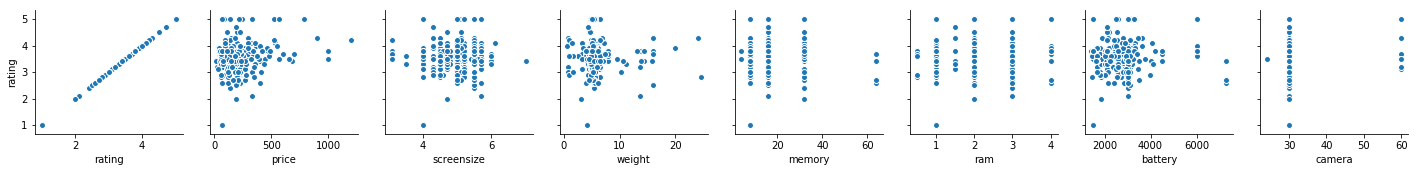

In [478]:
sns.pairplot(test_df, 
             y_vars = ['rating'],
             x_vars = ['rating', 'price', 'screensize', 'weight', 'memory', 'ram', 'battery', 'camera']);

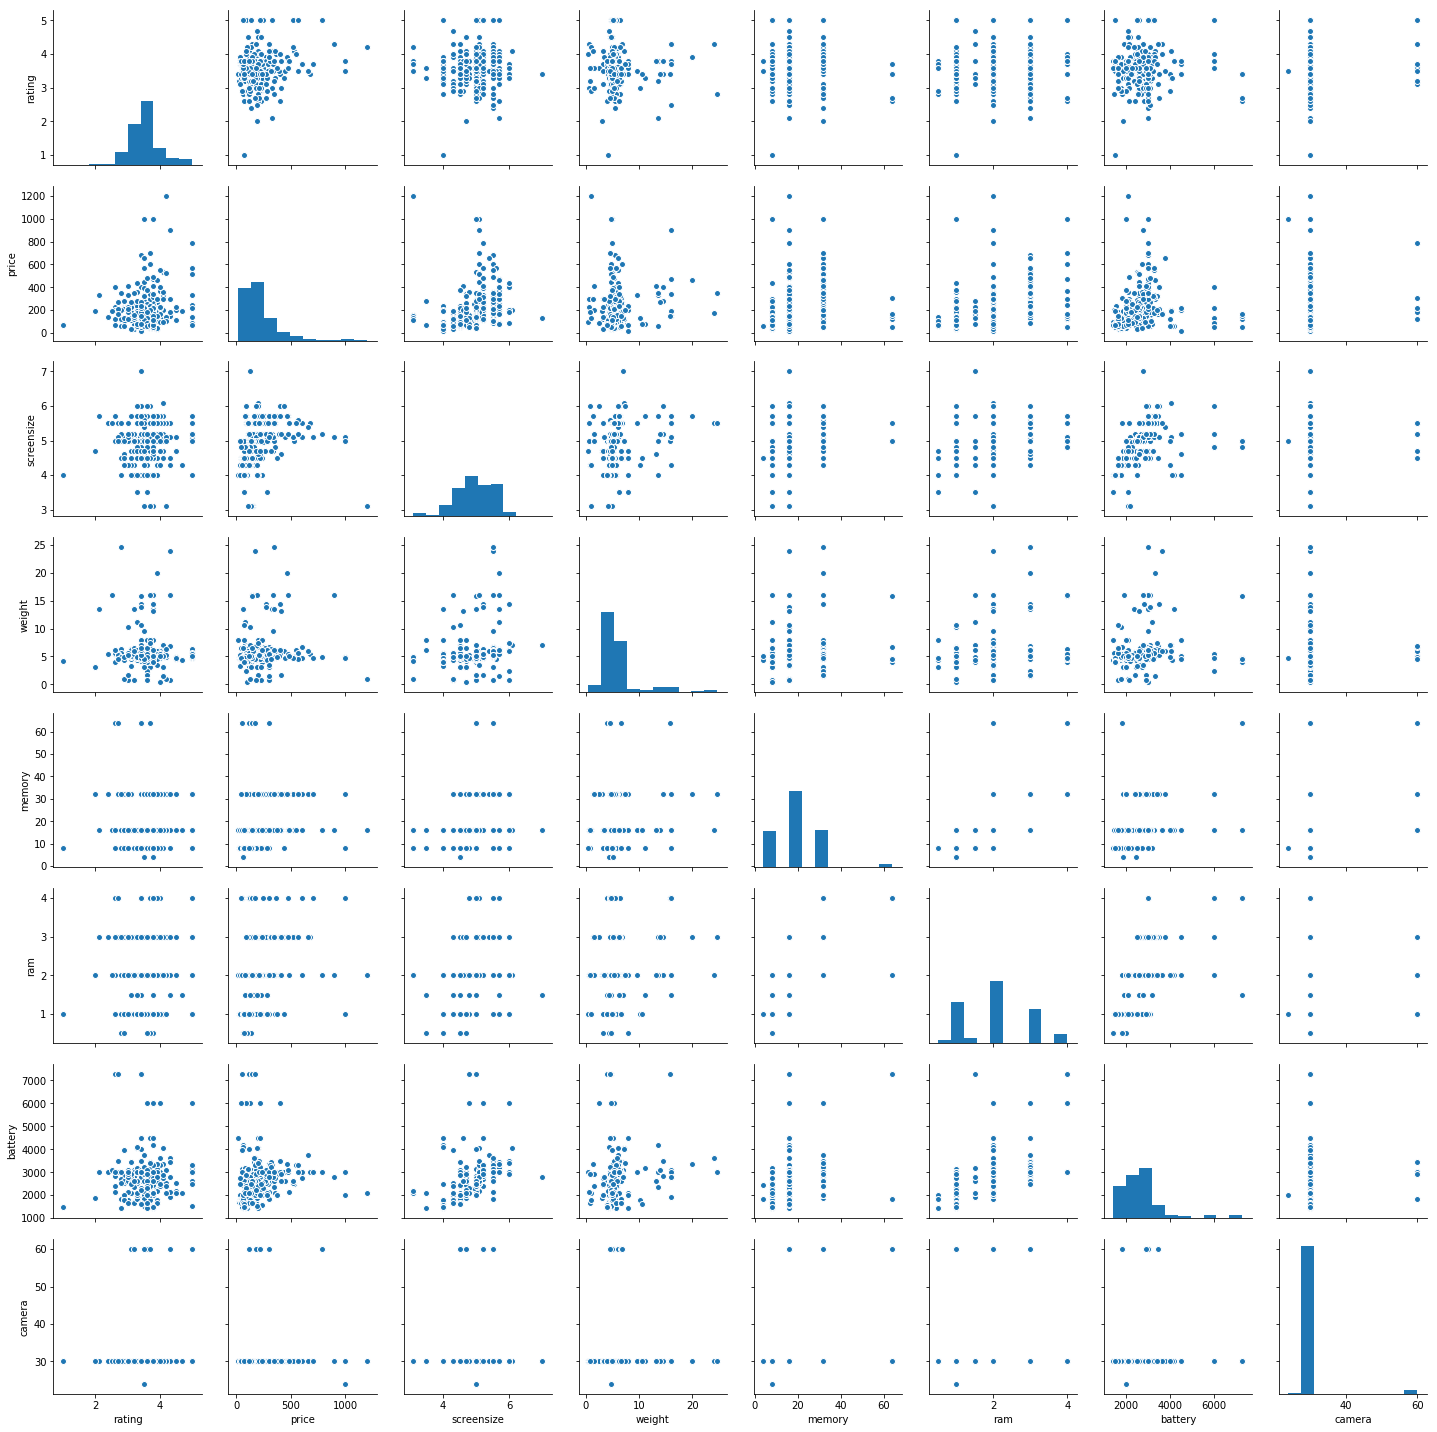

In [479]:
sns.pairplot(test_df)

In [863]:
#  1. Train Test Split

x = test_df[['price', 'screensize', 'weight', 'memory', 'ram', 'battery', 'camera']]
y = test_df['rating']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 25)

In [865]:
# 1.1 Train Test Split on Normalized Log features

x_log = test_df[['log_price', 'screensize', 'log_weight', 'log_memory', 'log_ram', 'log_battery', 'camera']]
y = test_df['rating']

X_train, X_test, y_train, y_test = train_test_split(x_log, y, test_size=0.2, random_state = 25)


In [790]:
# 2a. Within training set, perform Kfold -- for LinearRegression

kf = KFold(n=len(X_train), n_folds=5, shuffle=True, random_state=20)

all_scores_lr_train = []
all_scores_lr_test = []

for train, test in kf:
    Xt_train = x_log.iloc[train]
    yt_train = y.iloc[train]
    X_val = x_log.iloc[test]
    y_val = y.iloc[test]
    
    lr = LinearRegression()
    lr.fit(Xt_train, yt_train)
    all_scores_lr_train.append(lr.score(Xt_train, yt_train))
    all_scores_lr_test.append(lr.score(X_val, y_val))
    
np.mean(all_scores_lr_train), np.mean(all_scores_lr_test)

(0.04140894076727415, -0.07560275609321883)

In [703]:
# 2b. Within training set, perform Kfold -- for sm.OLS

kf = KFold(n=len(X_train), n_folds=5, shuffle=True, random_state=20)


all_scores_ols_train = []

for train, test in kf:
    Xt_train = x_log.iloc[train]
    yt_train = y.iloc[train]
    X_val = x_log.iloc[test]
    y_val = y.iloc[test]
    
    ols_model = sm.OLS(yt_train, sm.add_constant(Xt_train)).fit()
    all_scores_ols_train.append(ols_model.rsquared)
np.mean(all_scores_ols_train)

0.04140894076727406

In [712]:
# 2c. Within training set, perform Kfold -- for Lasso

kf = KFold(n=len(X_train), n_folds=5, shuffle=True, random_state=20)

all_mse_scores = []
all_scores_Lasso_train = []
all_scores_Lasso_test = []
alphas = [1e-5, 1e-3, 1e-1, 1]

for train, test in kf:
    Xt_train = x_log.iloc[train]
    yt_train = y.iloc[train]
    X_val = x_log.iloc[test]
    y_val = y.iloc[test]
    
    ssx = StandardScaler()
    ssx_Xt_train = ssx.fit_transform(Xt_train)
    ssx_X_val = ssx.transform(X_val)
    
    mse_scores = []
    for a in alphas:
        est = Lasso(alpha = a)
        est.fit(ssx_Xt_train, yt_train)
        mse = np.mean((y_val - est.predict(ssx_X_val))**2)
        mse_scores.append(mse)
    all_mse_scores.append(mse_scores)
        
    Lasso_est = Lasso(alpha = 1e-1)
    Lasso_est.fit(ssx_Xt_train, yt_train)
    all_scores_Lasso_train.append(Lasso_est.score(ssx_Xt_train, yt_train))
    all_scores_Lasso_test.append(Lasso_est.score(ssx_X_val, y_val))

np.mean(all_scores_Lasso_train), np.mean(all_scores_Lasso_test)

# to find alpha, accordingly to the list of 'alphas'   
#alpha_1 = []
#alpha_2 = []
#alpha_3 = []
#alpha_4 = []

#for element in all_mse_scores: 
#    alpha_1.append(element[0])
#    alpha_2.append(element[1])
#    alpha_3.append(element[2])
#    alpha_4.append(element[3])

#sum_alpha_list = [sum(alpha_1), sum(alpha_2), sum(alpha_3), sum(alpha_4)]
#print(sum_alpha_list)
#print(min(sum_alpha_list))

# so alpha = 1, get r2 = 0.0 so used alpha = 1e-1

(0.0011161627137411313, -0.023829479111649832)

In [777]:
# 2d. Within training set, perform Kfold -- for PolynomialFeatures

kf = KFold(n=len(X_train), n_folds=5, shuffle=True, random_state=20)

all_scores_poly_train = []
all_scores_poly_test = []

all_degree_scores_train = []
all_degree_scores_test = []

for train, test in kf:
    Xt_train = x_log.iloc[train]
    yt_train = y.iloc[train]
    X_val = x_log.iloc[test]
    y_val = y.iloc[test]
    
    degrees = []
    degree_scores_train = []
    degree_scores_test = []
    for degree in range(10):
        degrees.append(degree)
        poly_Xt_train = PolynomialFeatures(degree=degree).fit_transform(Xt_train)
        poly_X_val = PolynomialFeatures(degree=degree).fit_transform(X_val)

        lr = LinearRegression()
        lr_fit = lr.fit(poly_Xt_train, yt_train)
        
        degree_scores_train.append(lr_fit.score(poly_Xt_train, yt_train))
        degree_scores_test.append(lr_fit.score(poly_X_val, y_val))
     
    all_degree_scores_train.append(degree_scores_train)
    all_degree_scores_test.append(degree_scores_test)


In [787]:
# 2d(1). Within training set, perform Kfold -- for PolynomialFeatures of degree = 4

kf = KFold(n=len(X_train), n_folds=5, shuffle=True, random_state=20)

all_scores_poly_train = []
all_scores_poly_test = []

all_degree_scores_train = []
all_degree_scores_test = []

for train, test in kf:
    Xt_train = x_log.iloc[train]
    yt_train = y.iloc[train]
    X_val = x_log.iloc[test]
    y_val = y.iloc[test]
    
    poly_Xt_train = PolynomialFeatures(degree=4).fit_transform(Xt_train)
    poly_X_val = PolynomialFeatures(degree=4).fit_transform(X_val)

    lr = LinearRegression()
    lr_fit = lr.fit(poly_Xt_train, yt_train)
        
    all_degree_scores_train.append(lr_fit.score(poly_Xt_train, yt_train))
    all_degree_scores_test.append(lr_fit.score(poly_X_val, y_val))
     
np.mean(all_degree_scores_train), np.mean(all_degree_scores_test)

(0.9993784801570452, -804021454951.7971)

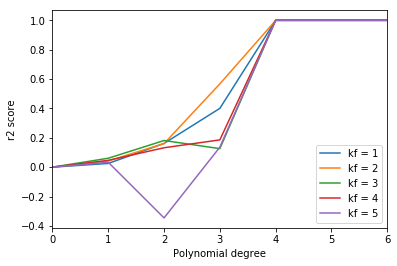

In [774]:
# from part 2d, plotting # of kfolds vs. r2 score for training set

kf_1 = all_degree_scores_train[0]
kf_2 = all_degree_scores_train[1]
kf_3 = all_degree_scores_train[2]
kf_4 = all_degree_scores_train[3]
kf_5 = all_degree_scores_train[4]

plt.plot(degrees, kf_1, degrees, kf_2, degrees, kf_3, degrees, kf_4, degrees, kf_5)
plt.xlabel('Polynomial degree')
plt.ylabel('r2 score')
plt.legend(['kf = 1', 'kf = 2', 'kf = 3', 'kf = 4', 'kf = 5'], loc=4)
plt.xlim(0,6)
plt.show()

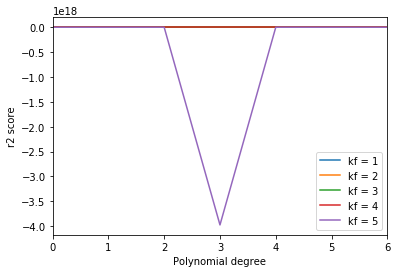

In [780]:
# continue from part 2d, plotting # of kfolds vs. r2 score for validation (test) set

kf_1_test = all_degree_scores_test[0]
kf_2_test = all_degree_scores_test[1]
kf_3_test = all_degree_scores_test[2]
kf_4_test = all_degree_scores_test[3]
kf_5_test = all_degree_scores_test[4]

plt.plot(degrees, kf_1_test, degrees, kf_2_test, degrees, kf_3_test, degrees, kf_4_test, degrees, kf_5_test)
plt.xlabel('Polynomial degree')
plt.ylabel('r2 score')
plt.legend(['kf = 1', 'kf = 2', 'kf = 3', 'kf = 4', 'kf = 5'], loc=4)
plt.xlim(0,6)
plt.show()

In [872]:
# 2e. Within training set, perform Kfold -- for RandomForest Regressor

kf = KFold(n=len(X_train), n_folds=5, shuffle=True, random_state=20)

all_scores_rf_train = []
all_scores_rf_test = []

for train, test in kf:
    Xt_train = x_log.iloc[train]
    yt_train = y.iloc[train]
    X_val = x_log.iloc[test]
    y_val = y.iloc[test]
    
    rf = RandomForestRegressor()
    rf_model = rf.fit(Xt_train, yt_train)
    
    
    all_scores_rf_train.append(rf_model.score(Xt_train, yt_train))
    all_scores_rf_test.append(rf_model.score(X_val, y_val))
    
np.mean(all_scores_rf_train), np.mean(all_scores_rf_test)



#rf = RandomForestRegressor(max_depth = 1,
#                               max_features = 'sqrt',
#                               max_leaf_nodes = 2,
#                               min_samples_leaf = 3,
#                               min_samples_split = 2,
#                               n_estimators = 10,
#                               random_state = 20)
#    rf_model = rf.fit(Xt_train, yt_train)


(0.7804592004694575, -0.4262709730538365)

In [860]:
rf = RandomForestRegressor(random_state=20)
   
params = {'n_estimators': [1,5,10,25], 
          'max_depth': [1,2,3], 
          'min_samples_split': [2,3], 
          'min_samples_leaf': [3,4,5], 
          'max_features': ['sqrt'], 
          'max_leaf_nodes': [2,3]}

gs = GridSearchCV(rf, param_grid=params, cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 10}

In [861]:
gs.cv_results_['mean_train_score']

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([-3.47597086e-05,  4.88284613e-02,  6.32528375e-02,  6.48179641e-02,
       -3.47597086e-05,  4.88284613e-02,  6.32528375e-02,  6.48179641e-02,
       -3.47597086e-05,  4.46334132e-02,  6.04242460e-02,  6.22598304e-02,
       -3.47597086e-05,  4.46334132e-02,  6.04242460e-02,  6.22598304e-02,
       -3.47597086e-05,  3.96460105e-02,  5.64225285e-02,  5.97454839e-02,
       -3.47597086e-05,  3.96460105e-02,  5.64225285e-02,  5.97454839e-02,
       -1.03356039e-03,  9.30243068e-02,  1.08563559e-01,  1.09873382e-01,
       -1.03356039e-03,  9.30243068e-02,  1.08563559e-01,  1.09873382e-01,
       -1.03356039e-03,  8.76136493e-02,  1.03950771e-01,  1.04433766e-01,
       -1.03356039e-03,  8.76136493e-02,  1.03950771e-01,  1.04433766e-01,
       -1.03356039e-03,  9.30584290e-02,  1.06085597e-01,  1.03636850e-01,
       -1.03356039e-03,  9.30584290e-02,  1.06085597e-01,  1.03636850e-01,
       -3.47597086e-05,  4.88284613e-02,  6.32528375e-02,  6.48179641e-02,
       -3.47597086e-05,  

In [862]:
gs.best_score_

-0.05827588408554083

In [868]:
# Run optimized RandomForest Regressor onto X_train and X_test to finalize and report score

rf = RandomForestRegressor(max_depth = 1,
                               max_features = 'sqrt',
                               max_leaf_nodes = 2,
                               min_samples_leaf = 3,
                               min_samples_split = 2,
                               n_estimators = 10,
                               random_state = 20)
rf_model = rf.fit(X_train, y_train)
rf_model.score(X_train, y_train), rf_model.score(X_test, y_test)

(0.04432060287944317, -0.025621560875007224)

In [874]:
rf = RandomForestRegressor()
rf_notoptimized = rf.fit(X_train, y_train)
rf_notoptimized.score(X_train, y_train), rf_notoptimized.score(X_test, y_test)

(0.8211440323637761, 0.11964200811075354)

In [870]:
ols_model = sm.OLS(y, sm.add_constant(x_log)).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.253
Date:                Fri, 20 Jul 2018   Prob (F-statistic):              0.275
Time:                        05:21:03   Log-Likelihood:                -190.42
No. Observations:                 251   AIC:                             396.8
Df Residuals:                     243   BIC:                             425.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.6923      1.126      2.392      0.018       0.475       4.910
log_price       0.1176      0.058      2.017      0.045       0.003       0.232
screensize     -0.0469      0.070     -0.674      0.501      -0.184       0.090
log_weight     -0.0164      0.068     -0.240      0.810      -0.151       0.118
log_memory     -0.1753      0.103     -1.702      0.090      -0.378       0.028
log_ram         0.1436      0.133      1.082      0.280      -0.118       0.405
log_battery     0.0878      0.147      0.597      0.551      -0.202       0.377
camera          0.0078      0.007      1.154      0.250      -0.006       0.021
==============================================================================
Omnibus:                       22.405   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.215
Skew:                          -0.183   Prob(JB):                     3.82e-18
Kurtosis:                       5.745   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

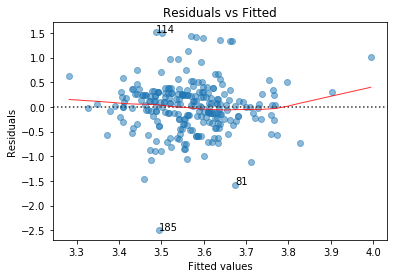

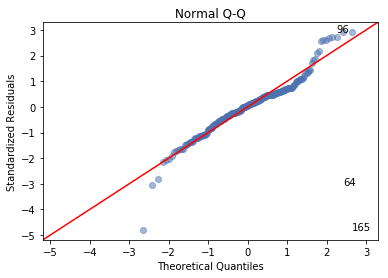

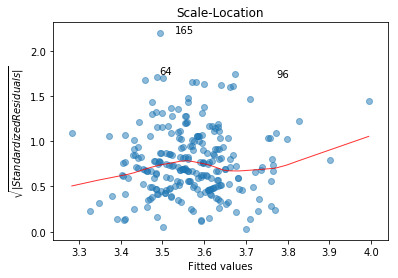

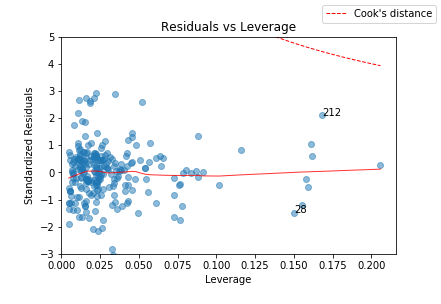

In [871]:
diagnostic_plots.diagnostic_plots(x_log, y, ols_model)

In [503]:
# Log Transform all features for easy access
log_price = test_df['price'].apply(lambda p: np.log(p))
log_weight = test_df['weight'].apply(lambda w: np.log(w))
log_memory = test_df['memory'].apply(lambda m: np.log(m))
log_ram = test_df['ram'].apply(lambda r: np.log(r))
log_battery = test_df['battery'].apply(lambda b: np.log(b))

log_screensize = test_df['screensize'].apply(lambda s: np.log(s))
log_camera = test_df['camera'].apply(lambda c: np.log(c))

test_df['log_price'] = log_price
test_df['log_weight'] = log_weight
test_df['log_memory'] = log_memory
test_df['log_ram'] = log_ram
test_df['log_battery'] = log_battery
test_df['log_screensize'] = log_screensize
test_df['log_camera'] = log_camera

test_df.head()

,rating,price,screensize,weight,memory,ram,battery,camera,log_price,log_weight,log_memory,log_ram,log_battery,log_screensize,log_camera
0,3.2,79.72,5.0,6.00,16,2.0,2800,30,4.378520,1.791759,2.772589,0.693147,7.937375,1.609438,3.401197
1,3.4,79.95,4.5,7.05,16,2.0,3100,30,4.381401,1.953028,2.772589,0.693147,8.039157,1.504077,3.401197
2,3.7,199.99,5.2,5.04,16,2.0,4500,30,5.298267,1.617406,2.772589,0.693147,8.411833,1.648659,3.401197
3,4.1,199.99,6.1,7.13,16,2.0,4050,30,5.298267,1.964311,2.772589,0.693147,8.306472,1.808289,3.401197
4,3.3,189.99,5.1,6.00,16,2.0,4050,30,5.246971,1.791759,2.772589,0.693147,8.306472,1.629241,3.401197
